### **Plant Seedling Classification -- To create a classifier capable of determining a plant's species from a photo**

In [184]:
# Loading Libraries
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import datasets, models, layers, optimizers
import tensorflow as tf
tf.__version__

'2.4.1'

In [185]:
# Loading the dataset
from google.colab import drive
drive.mount('/content/drive')
labels = pd.read_csv('/content/drive/My Drive/ComputerVision/Project/Labels.csv')
img_array = np.load('/content/drive/My Drive/ComputerVision/Project/images.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
# Visualizing the Label data in the Datasaet
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


Shape of DataSet

In [187]:
print("Shape of Image data--",img_array.shape)

Shape of Image data-- (4750, 128, 128, 3)


In [188]:
print("Shape of Labels Data--",labels.shape)

Shape of Labels Data-- (4750, 1)


In [189]:
# Visualizing the Label data in the Datasaet
labels['Label'][0]

'Small-flowered Cranesbill'

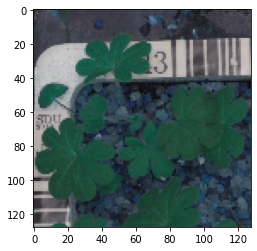

In [190]:
# Visualizing the Image data in the Dataset
img_temp=img_array[3]
plt.imshow(img_temp,cmap='gray')
plt.show()

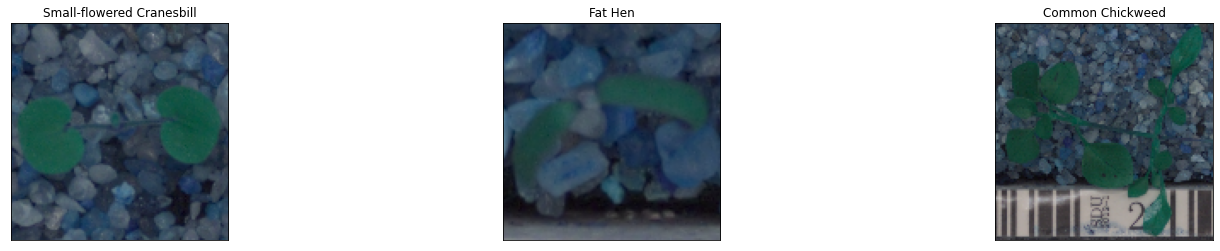

In [191]:
# Visualizing the Image data in the Dataset
fig = plt.figure(figsize=(25,4))
fig.add_subplot(1, 3 , 1, xticks=[], yticks=[])
tmp=img_array[0]
plt.title(labels['Label'][0])
plt.imshow(tmp,cmap='gray')

fig.add_subplot(1, 3 , 2, xticks=[], yticks=[])
tmp1=img_array[600]
plt.title(labels['Label'][600])
plt.imshow(tmp1,cmap='gray')

fig.add_subplot(1, 3 , 3, xticks=[], yticks=[])
tmp1=img_array[1500]
plt.title(labels['Label'][1500])
plt.imshow(tmp1,cmap='gray')

plt.show()

### Data PreProcessing

In [192]:
# Function for converting image to HSV format and creating mask for Green part of the image
def create_mask_seedling(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_grn = np.array([60 - sensitivity, 100, 50])
    upper_grn = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_grn, upper_grn)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

# Function for filtering out only Green part of the image, masking
def segment_seedling(image):
    mask = create_mask_seedling(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

# Function to sharpen the image, to remove the dots in the green part of the image, Guassian Blur
def sharpen_seedling(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp


In [193]:
# Normalization, Gaussian Blurring
trainImg = []
for i in range(img_array.shape[0]):
  img=img_array[i]
  img = cv2.resize(img,dsize=(32,32))
  img_stack = segment_seedling(img)
  img_stack = sharpen_seedling(img_stack)
  img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
  img_stack = np.reshape(img_stack,(32,32,1))
  #print(img_stack.shape)
  trainImg.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))
#print(new_img.shape)
#plt.imshow(new_img)
trainImg=np.array(trainImg)
trainImg=trainImg* 1/255

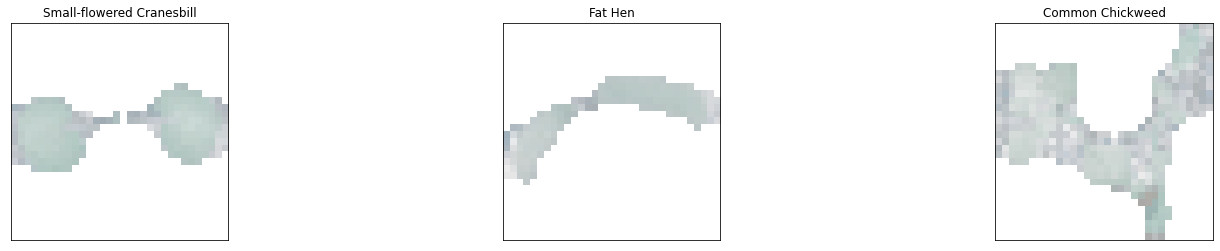

In [194]:
# Visulaization after pre-processing
fig = plt.figure(figsize=(25,4))
fig.add_subplot(1, 3 , 1, xticks=[], yticks=[])
tmp=trainImg[0]
plt.title(labels['Label'][0])
plt.imshow(tmp,cmap='gray')

fig.add_subplot(1, 3 , 2, xticks=[], yticks=[])
tmp1=trainImg[600]
plt.title(labels['Label'][600])
plt.imshow(tmp1,cmap='gray')

fig.add_subplot(1, 3 , 3, xticks=[], yticks=[])
tmp1=trainImg[1500]
plt.title(labels['Label'][1500])
plt.imshow(tmp1,cmap='gray')

plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64

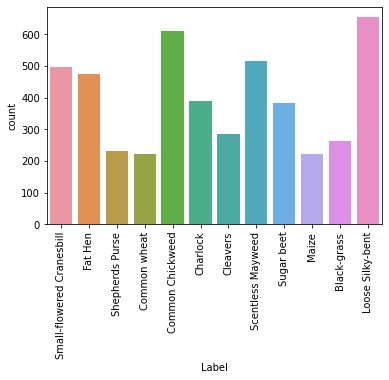

In [195]:
# Getting the Value Counts of the Images
plt.xticks(rotation=90)
g = sns.countplot(labels['Label'])
labels['Label'].value_counts()

In [196]:
print("Trainset Data Shape--",trainImg.shape)
#trainImg = trainImg.reshape(trainImg.shape[0], 32, 32, 1)

Trainset Data Shape-- (4750, 32, 32, 4)


### Make Data Compatible

In [197]:
# Convert labels to one-hot-vectors.
print(labels['Label'].shape)
print(labels['Label'][0])
map={"Label": {"Loose Silky-bent":0,"Common Chickweed":1,"Scentless Mayweed":2,"Small-flowered Cranesbill":3,"Fat Hen":4,
               "Charlock":5,"Sugar beet":6,"Cleavers":7,"Black-grass":8,"Shepherds Purse":9,"Common wheat":10,"Maize":11}}
labels=labels.replace(map)
Y = tf.keras.utils.to_categorical(labels['Label'],num_classes=12)

# Printing Label for y_train[0]
print(Y[0])

(4750,)
Small-flowered Cranesbill
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


### Split the dataset into training, testing, and validation set.

In [198]:
# Split data into test, validation and train set to build the model.

# First Splitting test size =.3 so taking train_size as size being .7
X_train, X_test, y_train, y_test = train_test_split(trainImg, Y, train_size=0.7, random_state=100)
# Splitting the test into vaidation and final test as size being .5 
X_val,X_final,y_val,y_final= train_test_split(X_test, y_test, train_size=0.5, random_state=100)

In [199]:
# Checking the shape of the data
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_final.shape)
print(y_final.shape)

(3325, 32, 32, 4)
(3325, 12)
(712, 32, 32, 4)
(712, 12)
(713, 32, 32, 4)
(713, 12)


### Building CNN

In [200]:
# Building Model
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:])) #32
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu")) #64
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation="relu")) #64
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu")) #64
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(12, activation="softmax"))

# Printing Model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        3232      
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 64)         

### Setting Optimizer and loss function

In [201]:
# Instantiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compliling Model with loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [202]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.0009' for more than 30 continous epochs
checkpoint_path = "Seedling_cnn_checkpoint.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0009, patience=30)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

#model_checkpoint =  ModelCheckpoint('Seedling_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
#                                    monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True,mode='auto',period=1)
model_checkpoint =  ModelCheckpoint('Seedling_cnn_checkpoint.h5',
                                    monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True,mode='auto',period=1)

### Fitting the Model

Epoch 1/150
104/104 [==============================] - 2s 9ms/step - loss: 2.6951 - accuracy: 0.1350 - val_loss: 2.4904 - val_accuracy: 0.1419

Epoch 00001: val_loss improved from inf to 2.49044, saving model to Seedling_cnn_checkpoint.h5
Epoch 2/150
104/104 [==============================] - 1s 6ms/step - loss: 2.0273 - accuracy: 0.2776 - val_loss: 3.4604 - val_accuracy: 0.1419

Epoch 00002: val_loss did not improve from 2.49044
Epoch 3/150
104/104 [==============================] - 1s 6ms/step - loss: 1.7736 - accuracy: 0.3788 - val_loss: 4.0695 - val_accuracy: 0.1419

Epoch 00003: val_loss did not improve from 2.49044
Epoch 4/150
104/104 [==============================] - 1s 6ms/step - loss: 1.5782 - accuracy: 0.4259 - val_loss: 2.5468 - val_accuracy: 0.1503

Epoch 00004: val_loss did not improve from 2.49044
Epoch 5/150
104/104 [==============================] - 1s 6ms/step - loss: 1.4600 - accuracy: 0.4784 - val_loss: 4.4381 - val_accuracy: 0.1433

Epoch 00005: val_loss did not im

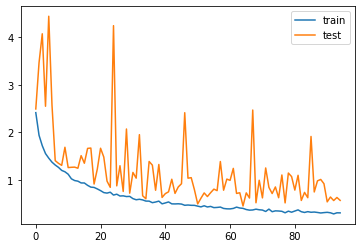

In [203]:
# Fitting the model
batch_size = 32
#batch_size = 256
num_classes = 12
epochs = 150


history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

# Plotting training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [204]:
# Evaluating the model on test data
scores=model.evaluate(X_final, y_final,verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 3ms/step - loss: 0.5013 - accuracy: 0.8499
Test loss: 0.5012751817703247
Test accuracy: 0.8499298691749573


In [205]:
# Getting the Predicted classes for Test Data 
y_fpred = model.predict_classes(X_final)
print(y_fpred)
rounded_test_labels = np.argmax(y_final, axis=1)

[ 0  2 11  7  0  0  7  1  3  9  7  2  3  0  3  1  2  4  2  0  5  1  2 11
  2  6  6  4  2  2  0  2  6  0 11 11  1  5  4  0  5  7  4  0  6  7 10 10
  3 11  0  5 11 11  8  1 10 10  1  3  2  3  4  5  9  5  6  2  1  4  4  4
  2  2  9  6  3  2  2  9  0  2  8  3  2  3  2  7 11  4  0  4  2  9  5  7
  7  1  4  4  3  4  0  3  2  0  2  5  1  0  1  7  5  7  2 10  7  2  6  7
  0 10  3  0  3 10  5  5  3  3  3  0  5  0  0  3  7 10  4  0  1  1  2  0
  0  8  0  9  4 11  1  6  9  1 11  0 10 10 10 11 11  9  9  8  9 10 10 11
  9  2  2  3  3  0  0  2  4  2  8  6  4  0  0  8  4  6  8  4  4  0  0  1
  6  0  0  4  1  1  1  2  0  6  2  1  5  0 10  3  3 11  0  1  2 10  6 10
  1  7  1  0  3  0  4  6  2  2  6  0  0  1  3  3  3  1  0 10 10  2  4  4
  0  3  0  0  2  1  3  1 11 10  7  8  3  0  8  0  3  7  3  1  3  8  5  0
  6  9 10  3  3  7  4  3  0  4  3  2  1  2  9  0  4  1  1  2  0  0 11  0
  0  1  4  0  7  8  7  0  9  6  1  0  2  2  2 11  3  1  4  1  0  1  1  3
  0  0 10  0  9  0  3  1  1 10  0  1 11  2 11  4  2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### Printing Confusion Matrix

In [206]:
print("=== Confusion Matrix ===")
cm = confusion_matrix(rounded_test_labels, y_fpred)
print(cm)

=== Confusion Matrix ===
[[95  0  1  0  0  0  0  0  2  0  0  0]
 [ 0 77  9  2  0  0  1  0  0  3  1  0]
 [ 0  1 73  0  0  1  0  0  0  1  0  0]
 [ 0  1  0 74  1  0  1  0  0  1  1  0]
 [ 3  1  2  4 64  1  0  0  3  1  0  1]
 [ 0  0  0  2  0 35  0  2  0  1  0  0]
 [ 0  0  1  0  2  0 37  0  0  0  1  2]
 [ 0  0  0  0  0  0  0 51  0  0  0  0]
 [30  0  2  0  0  0  0  0 11  0  1  0]
 [ 0  1  2  1  0  0  0  0  0 24  0  0]
 [ 6  0  0  1  2  0  0  0  4  0 32  0]
 [ 0  0  2  0  0  0  1  0  0  0  0 33]]


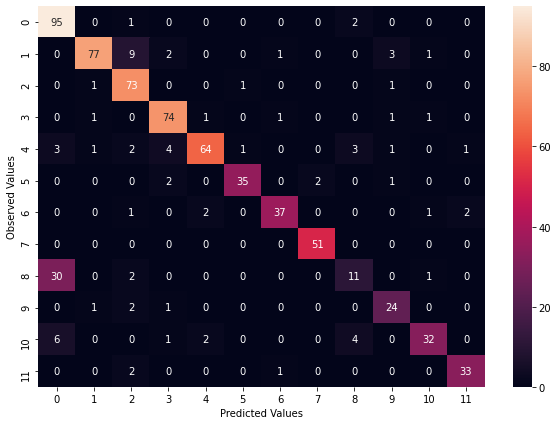

In [207]:
df_cm = pd.DataFrame(cm, index = [i for i in {0,1,2,3,4,5,6,7,8,9,10,11}],
                     columns = [i for i in {0,1,2,3,4,5,6,7,8,9,10,11}])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.ylabel('Observed Values')
plt.xlabel('Predicted Values')
plt.show()

### Printing Classification Report

In [208]:
print("=== Classification Report ===")
print(classification_report(rounded_test_labels, y_fpred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.71      0.97      0.82        98
           1       0.95      0.83      0.89        93
           2       0.79      0.96      0.87        76
           3       0.88      0.94      0.91        79
           4       0.93      0.80      0.86        80
           5       0.95      0.88      0.91        40
           6       0.93      0.86      0.89        43
           7       0.96      1.00      0.98        51
           8       0.55      0.25      0.34        44
           9       0.77      0.86      0.81        28
          10       0.89      0.71      0.79        45
          11       0.92      0.92      0.92        36

    accuracy                           0.85       713
   macro avg       0.85      0.83      0.83       713
weighted avg       0.85      0.85      0.84       713



### Visualize Predictions

('pred--', 11, ',Actual--', 11)


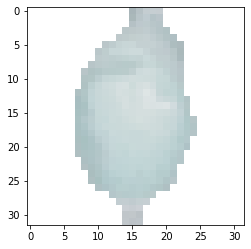

In [209]:
# X_final[2]
plt.imshow(X_final[2])
Title="pred--",y_fpred[2],",Actual--",rounded_test_labels[2]
print(Title)

('pred--', 7, ',Actual--', 7)


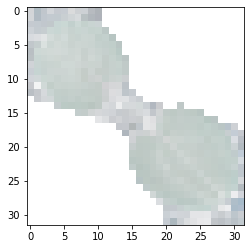

In [210]:
# X_final[3]
plt.imshow(X_final[3],cmap='gray')
Title="pred--",y_fpred[3],",Actual--",rounded_test_labels[3]
print(Title)

('pred--', 0, ',Actual--', 8)


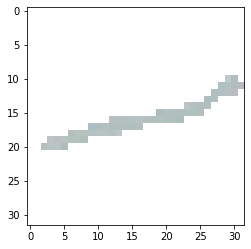

In [211]:
# X_final[33]
plt.imshow(X_final[33],cmap='gray')
Title="pred--",y_fpred[33],",Actual--",rounded_test_labels[33]
print(Title)

('pred--', 1, ',Actual--', 1)


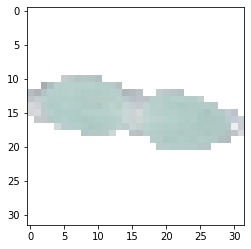

In [212]:
# X_final[36]
plt.imshow(X_final[36],cmap='gray')
Title="pred--",y_fpred[36],",Actual--",rounded_test_labels[36]
print(Title)

('pred--', 3, ',Actual--', 3)


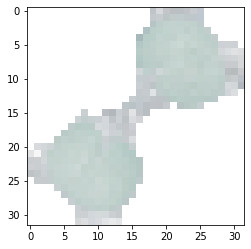

In [213]:
# X_final[59]
plt.imshow(X_final[59],cmap='gray')
Title="pred--",y_fpred[59],",Actual--",rounded_test_labels[59]
print(Title)